## Base libraries and tools imports

In [1]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import numpy as np
import os

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

2025-04-15 12:06:49.866369: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Dataset and Image Processing Functions

In [2]:
def load_dataset_files(directory):
    """Loads file paths and labels from the directory"""
    class_dirs = [d for d in os.listdir(directory) if os.path.isdir(os.path.join(directory, d))]
    classes = {class_name: i for i, class_name in enumerate(class_dirs)}

    file_paths = []
    labels = []

    for class_name in class_dirs:
        class_dir = os.path.join(directory, class_name)
        class_idx = classes[class_name]

        files = [os.path.join(class_dir, f) for f in os.listdir(class_dir)
                 if os.path.isfile(os.path.join(class_dir, f)) and
                 f.lower().endswith(('.png', '.jpg', '.jpeg'))]

        file_paths.extend(files)
        labels.extend([class_idx] * len(files))

    return file_paths, labels, classes

def process_image(file_path, label):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE)
    img = tf.cast(img, tf.float32) / 255.0

    label = tf.cast(label, tf.float32)
    return img, label

The load_dataset_files function recursively scans through a directory structure, where each subdirectory represents a class, and builds lists of file paths and corresponding labels. The process_image function handles the transformation pipeline for individual images, including reading the file, decoding the JPEG, resizing to the target dimensions, and normalizing pixel values to the [0,1] range for model compatibility.
## Test Dataset Creation

In [3]:
def create_test_dataset(test_dir, batch_size=BATCH_SIZE):
    file_paths, labels, classes = load_dataset_files(test_dir)

    print(f"Classes in the test set: {classes}")
    print(f"Number of test images: {len(file_paths)}")

    # Create test dataset
    test_ds = tf.data.Dataset.from_tensor_slices((file_paths, labels))
    test_ds = test_ds.map(process_image, num_parallel_calls=tf.data.AUTOTUNE)
    test_ds = test_ds.batch(batch_size, drop_remainder=True)
    test_ds = test_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

    # Calculate the number of steps
    test_steps = len(file_paths) // batch_size + (1 if len(file_paths) % batch_size != 0 else 0)

    return test_ds, test_steps, classes

This function prepares the test dataset for our image artifact classification model. It loads image files from the test directory, processes them to the required format, and organizes them into batches optimized for model evaluation.
## Loading dataset and models

In [5]:
test_ds, test_steps, test_classes = create_test_dataset(
    test_dir='/Users/maxim/Downloads/trainee_dataset/test',
    batch_size=BATCH_SIZE
)

model = tf.keras.models.load_model("best_model.keras", compile=False)

Classes in the test set: {'artifacts': 0, 'no artifacts': 1}
Number of test images: 200


## Model Evaluation
This code evaluates our trained artifact classification model using the test dataset. It makes predictions on test images, computes accuracy metrics, and visualizes performance through a classification report and confusion matrix to help us understand how well the model distinguishes between images with and without artifacts.

2025-04-15 12:13:39.229024: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



📊 Classification Report:
              precision    recall  f1-score   support

   artifacts       0.78      0.70      0.74        20
no artifacts       0.97      0.98      0.97       172

    accuracy                           0.95       192
   macro avg       0.87      0.84      0.85       192
weighted avg       0.95      0.95      0.95       192



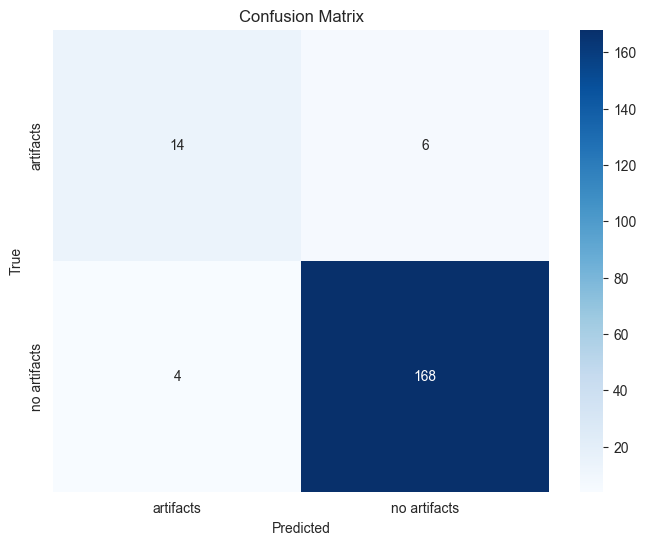

In [6]:
def evaluate_model_on_test(model, test_ds, test_steps, class_names=None):
    y_true = []
    y_pred = []

    for images, labels in test_ds.take(test_steps):
        preds = model.predict(images, verbose=0)

        # If the model returns probabilities
        if preds.shape[-1] > 1:
            pred_classes = np.argmax(preds, axis=1)
        else:
            pred_classes = (preds > 0.5).astype(int).flatten()

        y_pred.extend(pred_classes)
        y_true.extend(labels.numpy().astype(int))

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # ---- Metrics ----
    print("\n📊 Classification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))

    # ---- Confusion Matrix ----
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

    return {
        'y_true': y_true,
        'y_pred': y_pred,
        'confusion_matrix': cm,
        'report': classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
    }


results = evaluate_model_on_test(model, test_ds, test_steps, test_classes)



The model performs well overall with 95% accuracy, but shows room for improvement on the "artifacts" class. While the model correctly identifies non-artifacts (98% recall, 97% precision), it struggles more with detecting actual artifacts (70% recall). The confusion matrix reveals that 6 images with artifacts were incorrectly classified as having no artifacts (false negatives), and 4 images without artifacts were incorrectly flagged as containing artifacts (false positives). This imbalance likely stems from the highly skewed dataset (172 non-artifact vs. 20 artifact images), which affects the model's ability to generalize for the minority class.
## Visual Prediction Analysis

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


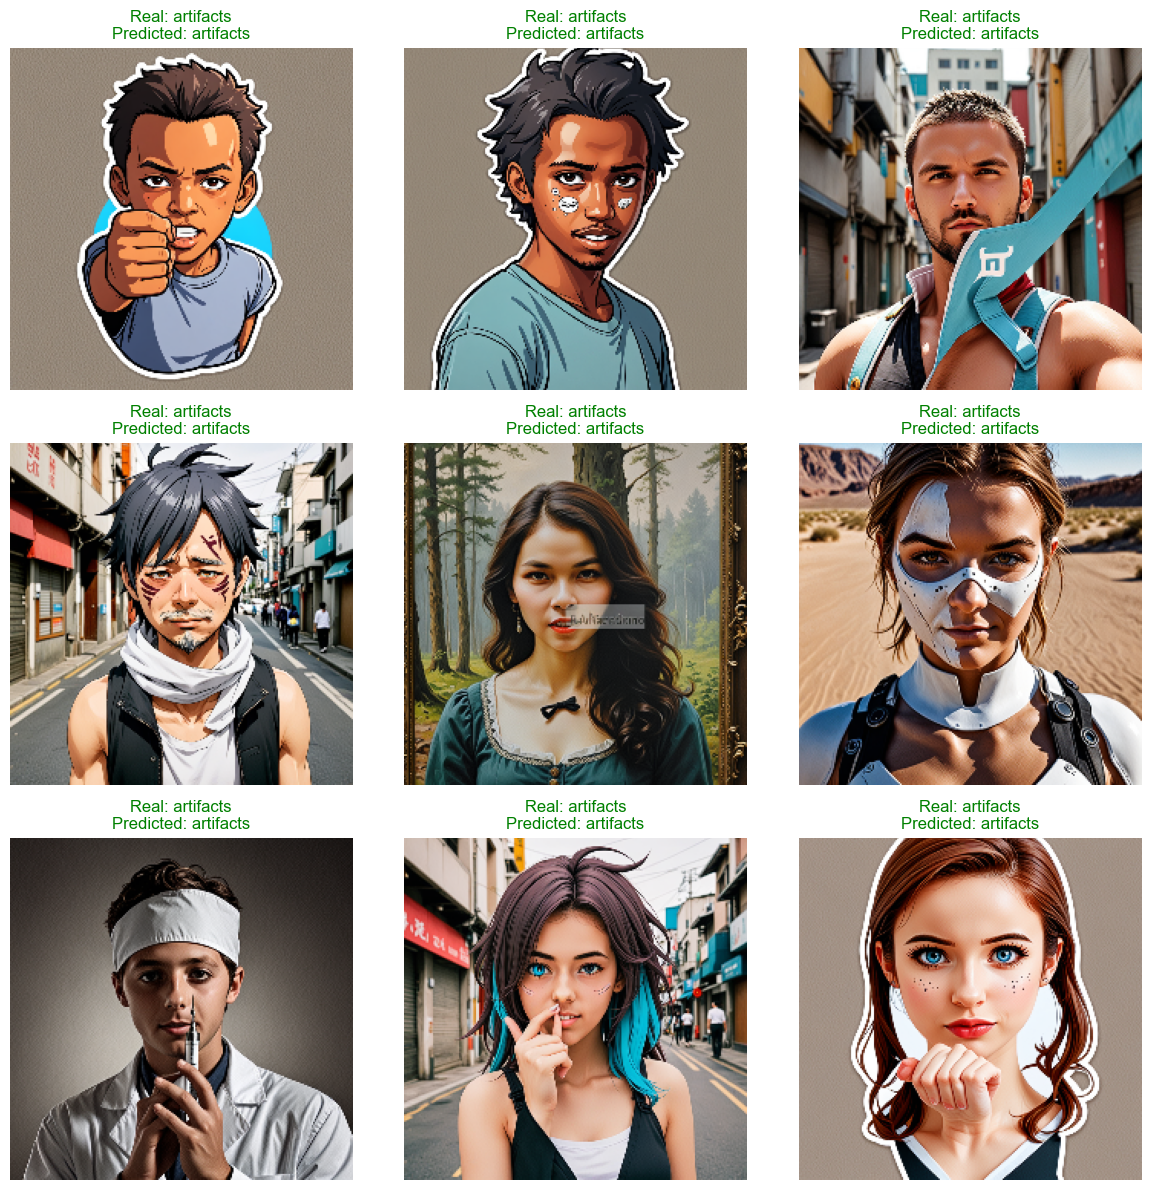

In [7]:
def visualize_model_predictions(model, test_dataset, classes, num_images=9):
    # Invert class dictionary to get class names by indexes
    class_names = {v: k for k, v in classes.items()}

    # Get the first batch_size of images and their labels
    images, labels = next(iter(test_dataset))

    if num_images > len(images):
        num_images = len(images)

    predictions = model.predict(images[:num_images])
    predicted_classes = np.argmax(predictions, axis=1)

    # Create a grid to display images
    rows = int(np.ceil(num_images / 3))
    cols = min(3, num_images)

    plt.figure(figsize=(12, 4 * rows))

    for i in range(num_images):
        plt.subplot(rows, cols, i + 1)

        # Display image
        img = images[i].numpy()
        plt.imshow(img)

        # Get real and predicted class labels
        true_label = int(labels[i].numpy())
        pred_label = predicted_classes[i]

        true_class_name = class_names[true_label]
        pred_class_name = class_names[pred_label]

        color = 'green' if true_label == pred_label else 'red'

        plt.title(f"Real: {true_class_name}\nPredicted: {pred_class_name}",
                  color=color)

        plt.axis('off')

    plt.tight_layout()
    plt.show()


visualize_model_predictions(model=model, test_dataset=test_ds, classes=test_classes, num_images=9)


Looking at some example predictions helps us understand where our model shines and where it struggles. The visualization displays 9 test images with their true labels and the model's predictions - correct matches are shown in green, while mistakes appear in red. This visual check gives us intuitive insight into what kinds of artifacts the model might be missing or what normal images it's falsely flagging, revealing patterns that purely numerical metrics might not capture.